### Load the required libraries

In [1]:
# Enable automiatic reload of libraries
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
!ls lib

Eigen_decomp.py  YearPlotter.tmp  numpy_pack.pyc   row_parser.pyc
Eigen_decomp.py~ binary_search.py recon_plot.py    spark_PCA.py
YearPlotter.py   computeStats.py  recon_plot.pyc
YearPlotter.pyc  numpy_pack.py    row_parser.py


In [5]:
from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [6]:
import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions
from recon_plot import recon_plot
from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter

In [7]:
data_dir='../../Data/Weather'
file_index='BBBSBBBB'

### Read the data frame from pickle file

In [8]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


In [9]:
#read data
filename=data_dir+'/US_Weather_BBBSBBBB.csv'
List=load(open(filename,'rb'))
print 'length of List=',len(List)

df=sqlContext.createDataFrame(List)
print df.count()
df.show(5)

length of List= 13047
13047
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     0|[80 4D 00 46 E0 5...|1931.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     0|[00 4F 80 51 00 4...|1932.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     2|[20 D0 00 53 A0 5...|1933.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     2|[30 55 80 C9 A0 D...|1934.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     1|[E0 50 00 CF 00 5...|1935.0|BBBSBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Read and process sample data

In [10]:
sqlContext.registerDataFrameAsTable(df,'weather')
#Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('SNWD','USC00198301')
Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%('SNWD')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='SNWD'
1321 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      6.1| 42.4667|    -70.9|       SNWD|USC00198301|     2|[00 00 00 00 00 0...|1949.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       SNWD|USC00198301|    30|[00 00 00 00 00 0...|1950.0|BBBSBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(1321, 365)

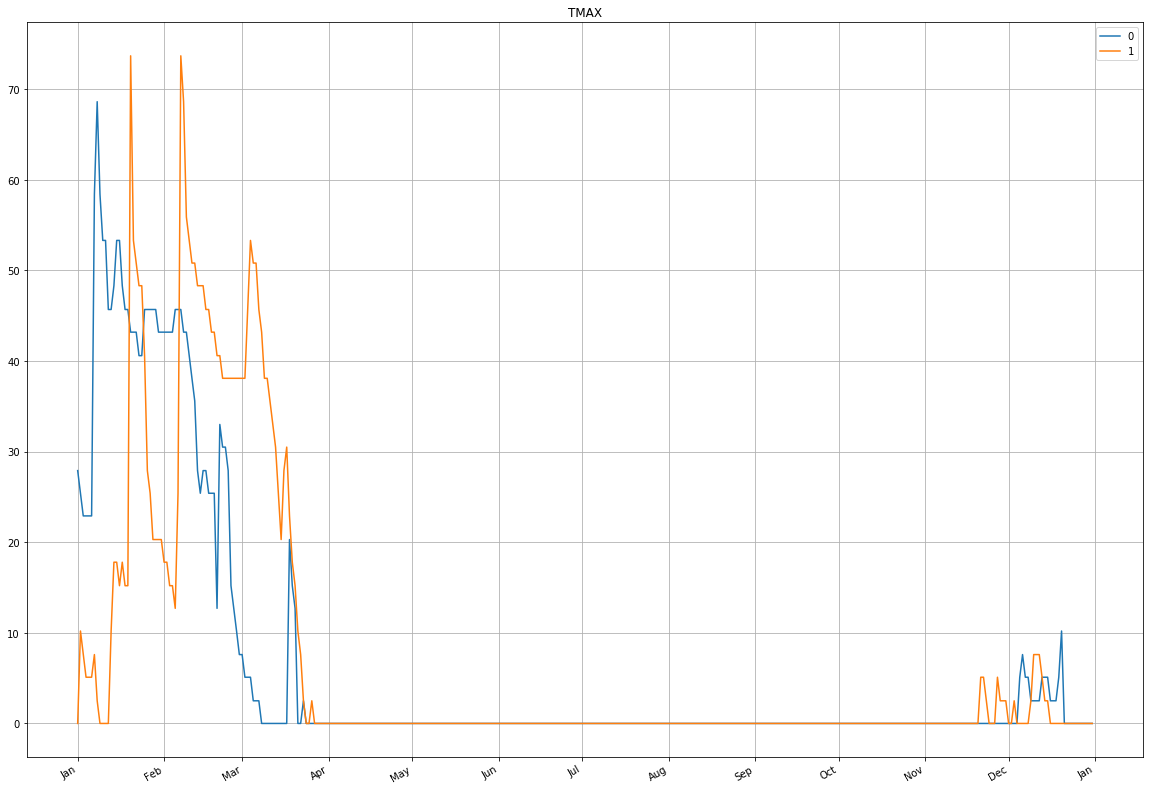

In [11]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(20,15));
YP=YearPlotter()
YP.plot(T[16:18].transpose(),fig,ax,title='TMAX')

### Plot Reconstructions

From each measurement, we take 4 sample stations with low residual error and 4 sample stations with high residual error and plot the following:

* Original Data Vector
* Reconstructed Data Vector from top 1 eigen vectors
* Reconstructed Data Vector from top 2 eigen vectors
* Reconstructed Data Vector from top 3 eigen vectors

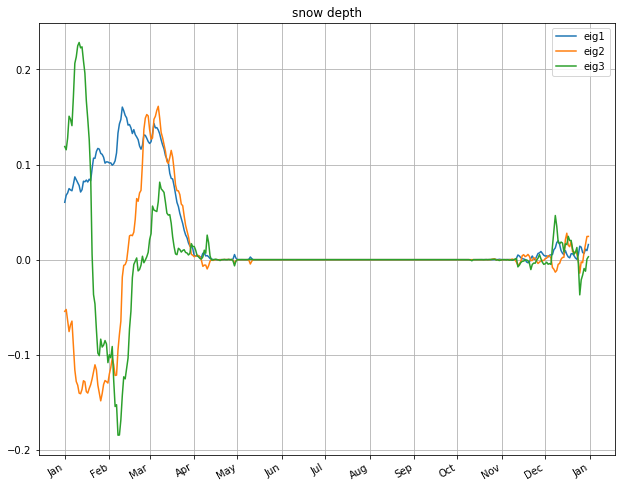

In [12]:
k=3
m='SNWD'
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
target=T[17,:]*10
fig=plt.figure(figsize=(8,6))
ax=fig.add_axes([0,0,1,1])
YearPlotter().plot(EigVec,fig,ax,title='snow depth',labels=['eig'+str(i+1) for i in range(k)])

In [13]:
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
eigen_decomp=Eigen_decomp(None,target,Mean,v)
eigen_decomp

<Eigen_decomp.Eigen_decomp instance at 0x10bf3ad88>

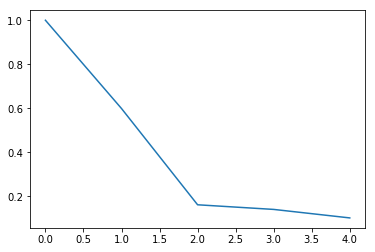

In [14]:
total_var,residuals,reductions=eigen_decomp.compute_var_explained()
plot([1]+list(residuals[1]))

In [15]:
import numpy as np
from ipywidgets import interactive,widgets

{'c2': <ipywidgets.widgets.widget_float.FloatSlider object at 0x116433dd0>, 'c1': <ipywidgets.widgets.widget_float.FloatSlider object at 0x116544ad0>, 'c0': <ipywidgets.widgets.widget_float.FloatSlider object at 0x11650f090>}


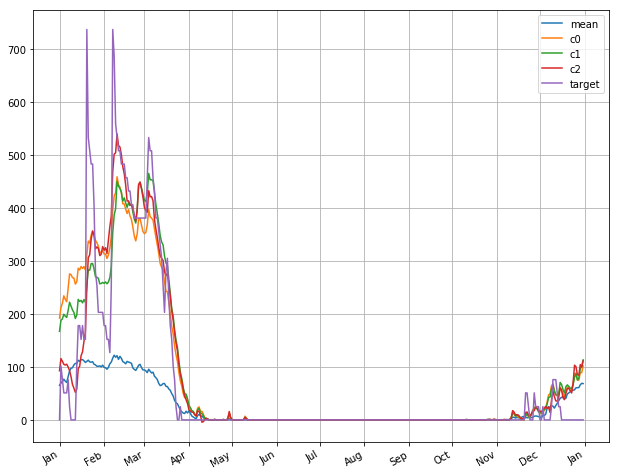

In [16]:
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
plotter=recon_plot(eigen_decomp,year_axis=True);
widge_list,widge_dict = plotter.get_widgets()
print widge_dict

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


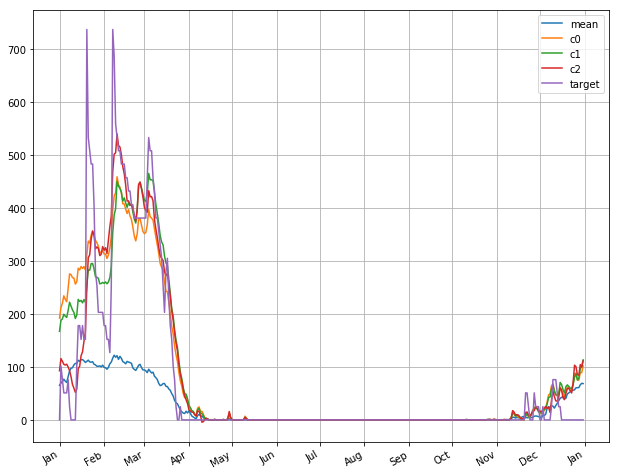

In [17]:
import numpy as np
from ipywidgets import interactive,widgets
from recon_plot import recon_plot
plotter=recon_plot(eigen_decomp,year_axis=True)
widge_list,widge_dict = plotter.get_widgets()
interactive(plotter.plot_combination, **widge_dict)
widgets.VBox([widgets.HBox(widge_list)])


### Process whole dataframe to find best and worse residuals

In [18]:
Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%('SNWD')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
#T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='SNWD'
1321 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      6.1| 42.4667|    -70.9|       SNWD|USC00198301|     2|[00 00 00 00 00 0...|1949.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       SNWD|USC00198301|    30|[00 00 00 00 00 0...|1950.0|BBBSBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(1321, 365)

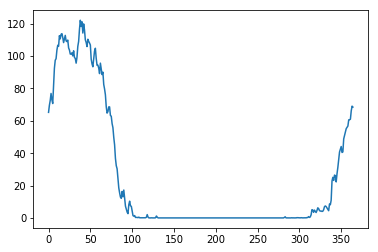

In [19]:
# compute eigen-decomposition for a single row 
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
plot(Mean)

In [108]:
from pyspark.sql.types import ArrayType
def decompose(row):
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions=recon.compute_var_explained()
    residuals=[float(r) for r in residuals[1]]
    D=row.asDict()
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
    return Row(**D)
    

In [155]:
row=df1.first()
row2=decompose(row)
#print np.isnan(row2.res_3)
x=row2.res_3
np.isnan(x)


True

In [142]:
from pyspark.sql.functions import col
df2.res_3.isNotNull()

Column<isnotnull(res_3)>

In [110]:
df1.select('vector').show(3)

+--------------------+
|              vector|
+--------------------+
|[00 00 00 00 00 0...|
|[00 00 00 00 00 0...|
|[00 7E 00 7E 00 7...|
+--------------------+
only showing top 3 rows



In [162]:
import numpy
rdd2=df1.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
print 'before filter',df2.count()
df3=df2.filter(df2.res_3 != np.nan)
print 'after filter',df3.count()

before filter 1321
after filter 816


In [168]:
df3.sort(df3.res_3)
df3.show(5)

+---------+--------+--------+---------+-----------+--------------------+--------------------+--------------------+------------------+-----------+------+--------------------+------+
|elevation|   label|latitude|longitude|measurement|               res_1|               res_2|               res_3|          res_mean|    station|undefs|              vector|  year|
+---------+--------+--------+---------+-----------+--------------------+--------------------+--------------------+------------------+-----------+------+--------------------+------+
|     29.9|BBBSBBBB|    42.2|    -72.6|       SNWD|  0.3120132495875395|   0.126604424190932|  0.0330024968075879|0.6341531809301924|USC00193702|     0|[F0 5B 28 5B 60 5...|1961.0|
|    100.9|BBBSBBBB|   42.55|   -71.75|       SNWD|0.041426294985629025|0.041196025381433944| 0.03310388652160637|0.6221958608220206|USC00192806|     0|[5C 5C 58 5E F4 5...|1971.0|
|     25.3|BBBSBBBB| 42.5242| -71.1264|       SNWD|  0.3977790081576867| 0.04779472976035723| 0

In [62]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType,NumericType,DataType,FloatType,DoubleType

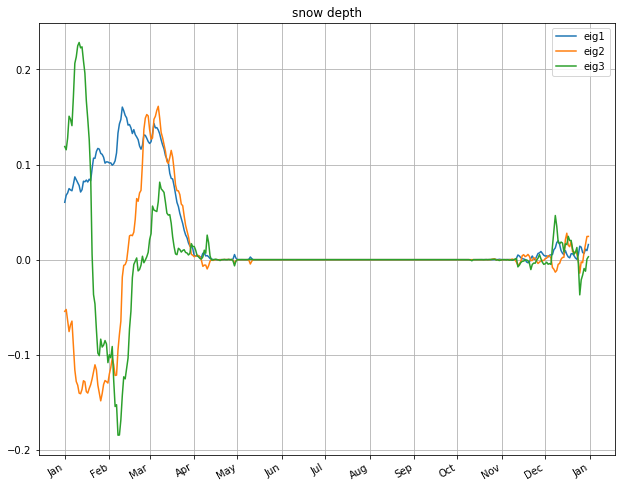

In [170]:
k=3
m='SNWD'
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
Mean=STAT[m]['Mean']
fig=plt.figure(figsize=(8,6))
ax=fig.add_axes([0,0,1,1])
YearPlotter().plot(EigVec,fig,ax,title='snow depth',labels=['eig'+str(i+1) for i in range(k)])

In [175]:
from ipywidgets import interactive,widgets
from recon_plot import recon_plot

rows=df3.tail(20)

AttributeError: 'DataFrame' object has no attribute 'tail'

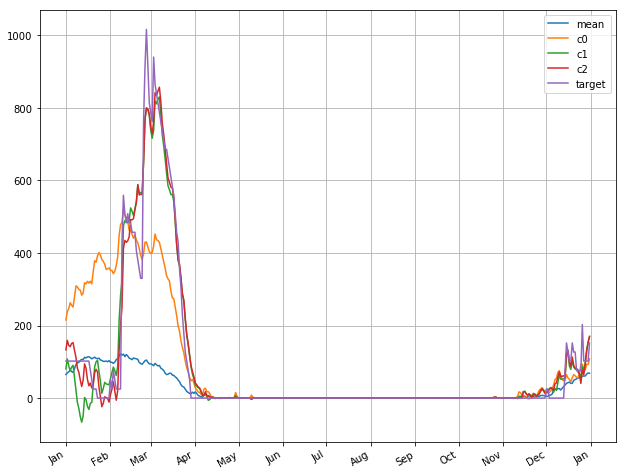

In [174]:
row=rows[2]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
plotter=recon_plot(eigen_decomp,year_axis=True)
widge_list,widge_dict = plotter.get_widgets()
interactive(plotter.plot_combination, **widge_dict)
widgets.VBox([widgets.HBox(widge_list)])

## Old Code

In [ ]:
for m in ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']:
    print 'Reconstruction Plots for '+ m
    create_reconstructions(m)